In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

### Function to run inference on a single image

In [2]:
def run_inference_single_image(model,image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    input_tensor = input_tensor[tf.newaxis,...]
    model_fn = model.signatures["serving_default"]
    output = model_fn(input_tensor)

    num_detections = int(output.pop("num_detections"))
    output = {key:value[0, :num_detections].numpy() for key,value in output.items()}
    output['num_detections'] = num_detections
    output['detection_classes']=output['detection_classes'].astype(np.int64)

     
    return output

In [3]:
LABEL_PATH = '/home/thirumalaikumar/Intern Projects/TrafficControl/content/sub_surf/gate_label_map.pbtxt'
ci = label_map_util.create_category_index_from_labelmap(LABEL_PATH,use_display_name=True)

In [4]:
def show_inference(model,frame):
    image_np = np.array(frame)
    output = run_inference_single_image(model,image_np)

    classes = np.squeeze(output['detection_classes'])#class to which the object belongs to
    boxes = np.squeeze(output['detection_boxes'])#box coords
    scores = np.squeeze(output['detection_scores'])#prob score of the model

#condition for Detecting only the gate 
    indices = np.argwhere(classes==2)
    boxes = np.squeeze(boxes[indices])
    classes = np.squeeze(classes[indices])
    scores = np.squeeze(scores[indices])

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np,
        boxes,
        classes,
        scores,
        ci,
        use_normalized_coordinates=True,
        max_boxes_to_draw=100,
        min_score_thresh=.8,
        agnostic_mode=False,
        
    )
    return image_np

In [5]:
model = tf.saved_model.load("/home/thirumalaikumar/Intern Projects/TrafficControl/content/sub_surf/saved_model")

4) with ops with custom gradients. Will likely fail if a gradient is requested.


In [6]:
import cv2

In [7]:
def post_process_bb(model,img,threshold=0.5):
    img = cv2.imread(img)
    output = run_inference_single_image(model,img)
    assert len(output['detection_boxes']) == len(output['detection_scores'])
    max_score_index = np.squeeze(np.argwhere(output['detection_scores']>=threshold))
    detection_score = output['detection_scores'][max_score_index]
    box_coords = output['detection_boxes'][max_score_index]
    detecction_class = output['detection_classes'][max_score_index]
    return img,detection_score,detecction_class,box_coords

In [18]:
def midpoint():
    img,score,classes,coords = post_process_bb(model,"/home/thirumalaikumar/Downloads/WhatsApp Image 2020-10-31 at 11.54.49.jpeg")
    im_width = img.shape[0]
    im_height = img.shape[1]
    try:
        coords = coords.reshape(1,coords.shape[0])
    except ValueError as v:
        print("Your Object detector has detected more than 1 BB")
    print(coords.shape)
    for i in range(len(coords)):
        x1,y1,x2,y2 = coords[i]
        (left, right, top, bottom) = (y1 * im_width, y2 * im_width, 
                                x1 * im_height, x2 * im_height)
        p1 = (int(left), int(top))
        p2 = (int(right), int(bottom))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        _ = cv2.rectangle(img, p1, p2, (255,0,0), 15)
        
        x_center = int((left+right)/2)
        y_center = int(bottom)

        x2_center = int((left+right)/2)
        y2_center = int(top)
        
        center1 = (x_center, y_center)
        center2 = (x2_center,y2_center)
        res = tuple(map(lambda i, j: i + j, center1, center2))
        res = tuple(map(lambda i: i / 2, res))
        res = tuple(map(lambda i: int(i) , res))
        img1 = cv2.circle(img,res, 15, (0, 255, 0), -1)
        #cv2.putText(img1,"Gate",p1, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return img1

(1, 4)


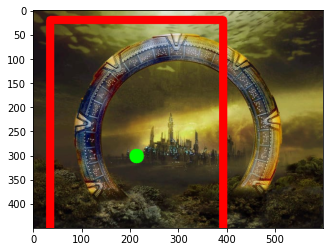

In [19]:
plt.imshow(midpoint())

In [24]:
vid = cv2.VideoCapture(0) 
  
while(True): 
      
    # Capture the video frame 
    # by frame 
    ret, frame = vid.read() 
    imagen = show_inference(model,frame)
    # Display the resulting frame 
    cv2.imshow('frame', cv2.resize(imagen,(800,600))) 
      
    # the 'q' button is set as the 
    # quitting button you may use any 
    # desired button of your choice 
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
  
# After the loop release the cap object 
vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 